# Autoformer - 时间序列预测模型（训练前后对比版）
## Bitcoin 数据集版本

**本 Notebook 使用 From_News_to_Forecast 项目的比特币数据进行训练**

数据集特点：
- 📊 数据源：比特币历史数据 (2009-2021)
- ⏰ 时间频率：每日数据
- 📈 数据量：4,521 条记录（约12年数据）
- 🎯 目标变量：price (比特币价格)
- 💰 特征数量：14个（价格、市值、交易量、算力、Google趋势等）

主要特征：
- price - 价格
- market_cap - 市值
- transactions - 交易数
- active_addresses - 活跃地址数
- hashrate - 算力
- difficulty - 挖矿难度
- google_trends - Google搜索趋势
- tweets - Twitter提及数

功能亮点：
- ✨ **训练前后效果对比**
- ✨ **性能提升可视化**
- ✨ **详细的改进分析**
- ✨ **Informer 风格的精美图表**

论文：[Autoformer: Decomposition Transformers with Auto-Correlation for Long-Term Series Forecasting](https://arxiv.org/abs/2106.13008)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 环境设置与依赖安装

In [ ]:
# 检测运行环境
import os
import sys

IN_TIANCHI = os.path.exists('/tcdata') or os.path.exists('/home/tianchi')

if IN_TIANCHI:
    print("✓ 检测到阿里天池环境")
    WORK_DIR = '/home/tianchi' if os.path.exists('/home/tianchi') else os.getcwd()
else:
    print("检测到本地或其他环境")
    WORK_DIR = os.getcwd()

print(f"工作目录: {WORK_DIR}")
os.chdir(WORK_DIR)

检测到本地或其他环境
工作目录: /content


In [ ]:
# 配置pip使用阿里云镜像
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!pip config set install.trusted-host mirrors.aliyun.com

# 安装依赖
!pip install -q pandas scikit-learn numpy matplotlib -i https://mirrors.aliyun.com/pypi/simple/

try:
    import torch
    print(f"✓ PyTorch已安装: {torch.__version__}")
except:
    !pip install -q torch torchvision -i https://mirrors.aliyun.com/pypi/simple/

!pip install -q reformer-pytorch -i https://mirrors.aliyun.com/pypi/simple/

print("\n✓ 所有依赖安装完成")

Writing to /root/.config/pip/pip.conf
Writing to /root/.config/pip/pip.conf
✓ PyTorch已安装: 2.8.0+cu126

✓ 所有依赖安装完成


In [ ]:
# 克隆代码仓库
if not os.path.exists('Autoformer'):
    print("正在克隆代码仓库...")
    !git clone https://github.com/thuml/Autoformer.git
    print("✓ 代码仓库克隆完成")
else:
    print("✓ 代码仓库已存在")

if os.path.exists('Autoformer'):
    os.chdir('Autoformer')
    print(f"当前目录: {os.getcwd()}")

✓ 代码仓库已存在
当前目录: /content/Autoformer


## 2. 导入库

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import copy
from tqdm import tqdm
warnings.filterwarnings('ignore')

# NumPy 2.0 兼容性修复
import numpy as np
np_version = np.__version__
if int(np_version.split('.')[0]) >= 2:
    print(f"⚠️  检测到 NumPy {np_version}（2.0+），应用兼容性修复...")
    # 临时兼容：如果代码使用了旧的 np.Inf，自动修复
    if not hasattr(np, 'Inf'):
        np.Inf = np.inf
        np.NaN = np.nan
        np.NINF = np.NINF if hasattr(np, 'NINF') else -np.inf
        np.PINF = np.PINF if hasattr(np, 'PINF') else np.inf
    print("✅ NumPy 2.0 兼容性修复已应用")
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(fix_seed)

print("="*50)
print("环境信息")
print("="*50)
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*50)

⚠️  检测到 NumPy 2.0.2（2.0+），应用兼容性修复...
✅ NumPy 2.0 兼容性修复已应用
环境信息
PyTorch版本: 2.8.0+cu126
CUDA是否可用: True
GPU名称: Tesla T4
GPU内存: 14.74 GB


In [ ]:
# 导入项目模块
from exp.exp_main import Exp_Main
from utils.tools import dotdict
from utils.metrics import metric

print("✓ 项目模块导入成功")

✓ 项目模块导入成功


## 3. 数据集准备

本 Notebook 使用 **Bitcoin 数据集** (来自 From_News_to_Forecast 项目)

In [ ]:
# 准备比特币数据集
import sys
sys.path.append('..')

# 运行数据预处理脚本
#print("正在准备 Bitcoin 数据集...")
#exec(open('../prepare_bitcoin_data.py').read())

# 验证数据
import pandas as pd
data_path = '/content/bitcoin/bitcoin.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"\n✓ 数据已准备完成!")
    print(f"  数据形状: {df.shape}")
    print(f"  时间范围: {df['date'].min()} 至 {df['date'].max()}")
    print(f"  特征列: {df.columns.tolist()[1:]}")  # 除去date列
else:
    print("❌ 数据准备失败！")


❌ 数据准备失败！


## 4. 配置参数

In [ ]:
# 创建配置
args = dotdict()

# 基本配置
args.is_training = 1
args.model_id = 'Bitcoin_60_7'
args.model = 'Autoformer'

# 数据配置 - 使用 Bitcoin 数据集
args.data = 'custom'  # 使用自定义数据集
args.root_path = '/content/'
args.data_path = 'bitcoin.csv'
args.features = 'M'  # 多变量预测
args.target = 'price'  # 目标变量：比特币价格
args.freq = 'd'  # 日度数据
args.checkpoints = './checkpoints/'

# 预测任务配置（适合日度数据）
args.seq_len = 60   # 输入序列长度（60天）
args.label_len = 30  # decoder 起始长度（30天）
args.pred_len = 7   # 预测长度（7天，即一周）

# 模型配置 - 根据数据特征数调整
args.enc_in = 14   # 14个输入特征
args.dec_in = 14   # 14个解码器输入特征
args.c_out = 14    # 14个输出特征
args.d_model = 512
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.dropout = 0.05
args.embed = 'timeF'
args.activation = 'gelu'
args.output_attention = False
args.do_predict = False

# Reformer参数
args.bucket_size = 4
args.n_hashes = 4

# 训练配置
args.num_workers = 0
args.itr = 1
args.train_epochs = 10  # 训练轮数（比特币数据量较小，可以多训练几轮）
args.batch_size = 32
args.patience = 3
args.learning_rate = 0.0001
args.des = 'Bitcoin_Exp'
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False

# GPU配置
args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0'

print("="*60)
print("✓ 参数配置完成 - Bitcoin 数据集")
print("="*60)
print(f"数据集: {args.data_path}")
print(f"特征数: {args.enc_in}")
print(f"序列长度: 输入={args.seq_len}天, 预测={args.pred_len}天")
print(f"训练轮数: {args.train_epochs}")
print(f"设备: {'GPU' if args.use_gpu else 'CPU'}")
print("="*60)


✓ 参数配置完成 - Bitcoin 数据集
数据集: bitcoin.csv
特征数: 14
序列长度: 输入=60天, 预测=7天
训练轮数: 10
设备: GPU


## 5. 训练前评估（保存初始模型）

In [ ]:
# 设置GPU
if args.use_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    torch.cuda.set_device(args.gpu)

# 生成实验标识
setting = '{}_{}_{}_{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
    args.model_id,
    args.model,
    args.data,
    args.features,
    args.seq_len,
    args.label_len,
    args.pred_len,
    args.d_model,
    args.n_heads,
    args.e_layers,
    args.d_layers,
    args.d_ff,
    args.factor,
    args.embed,
    args.distil,
    args.des, 0)

print(f'实验标识: {setting}')

实验标识: Bitcoin_60_7_Autoformer_custom_M_sl60_ll30_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Bitcoin_Exp_0


In [ ]:
# 创建实验实例
Exp = Exp_Main
exp = Exp(args)

print("✓ 实验实例创建完成")

Use GPU: cuda:0
✓ 实验实例创建完成


In [ ]:
# 评估训练前的模型性能
print("\n" + "="*80)
print("训练前模型评估（随机初始化）")
print("="*80)

# 获取测试数据
test_data, test_loader = exp._get_data(flag='test')

# 保存初始模型状态
initial_model_state = copy.deepcopy(exp.model.state_dict())

# 在初始模型上测试
exp.model.eval()
preds_before = []
trues_before = []

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # 解码器输入
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp.device)

        # 预测
        outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, f_dim:]
        batch_y = batch_y[:, -args.pred_len:, f_dim:].to(exp.device)

        pred = outputs.detach().cpu().numpy()
        true = batch_y.detach().cpu().numpy()

        preds_before.append(pred)
        trues_before.append(true)

# 计算初始性能
preds_before = np.concatenate(preds_before, axis=0)
trues_before = np.concatenate(trues_before, axis=0)

mae_before, mse_before, rmse_before, mape_before, mspe_before = metric(preds_before, trues_before)

print(f"\n训练前性能指标:")
print(f"  MAE:  {mae_before:.6f}")
print(f"  MSE:  {mse_before:.6f}")
print(f"  RMSE: {rmse_before:.6f}")
print(f"  MAPE: {mape_before:.6f}")
print(f"  MSPE: {mspe_before:.6f}")

print("\n✓ 训练前评估完成，已保存初始模型状态")


训练前模型评估（随机初始化）
test 898

训练前性能指标:
  MAE:  0.597980
  MSE:  0.598466
  RMSE: 0.773606
  MAPE: 2.211038
  MSPE: 608.383362

✓ 训练前评估完成，已保存初始模型状态


## 6. 训练模型

In [ ]:
# 开始训练
print("\n" + "="*80)
print("开始训练")
print("="*80)

exp.train(setting)

print("\n✓ 训练完成")


开始训练
train 3098
val 447
test 898
Epoch: 1 cost time: 6.875089406967163
Epoch: 1, Steps: 96 | Train Loss: 0.2986027 Vali Loss: 0.7749883 Test Loss: 0.3591408
Validation loss decreased (inf --> 0.774988).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 5.818544387817383
Epoch: 2, Steps: 96 | Train Loss: 0.1693588 Vali Loss: 0.7936955 Test Loss: 0.3883501
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
Epoch: 3 cost time: 5.808478593826294
Epoch: 3, Steps: 96 | Train Loss: 0.1267541 Vali Loss: 0.7367045 Test Loss: 0.3655218
Validation loss decreased (0.774988 --> 0.736705).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 5.89408540725708
Epoch: 4, Steps: 96 | Train Loss: 0.1117739 Vali Loss: 0.7710273 Test Loss: 0.3460098
EarlyStopping counter: 1 out of 3
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 5.881563901901245
Epoch: 5, Steps: 96 | Train Loss: 0.1037207 Vali Loss: 0.7800213 Test Loss: 0.3481979
EarlyStoppin

## 7. 训练后评估

In [ ]:
# 测试训练后的模型
print("\n" + "="*80)
print("训练后模型评估")
print("="*80)

exp.test(setting)

# 加载测试结果
result_path = f'./results/{setting}/'
preds_after = np.load(f'{result_path}pred.npy')
trues_after = np.load(f'{result_path}true.npy')

# 计算训练后性能
mae_after, mse_after, rmse_after, mape_after, mspe_after = metric(preds_after, trues_after)

print(f"\n训练后性能指标:")
print(f"  MAE:  {mae_after:.6f}")
print(f"  MSE:  {mse_after:.6f}")
print(f"  RMSE: {rmse_after:.6f}")
print(f"  MAPE: {mape_after:.6f}")
print(f"  MSPE: {mspe_after:.6f}")

print("\n✓ 训练后评估完成")


训练后模型评估
test 898
test shape: (898, 7, 14) (898, 7, 14)
test shape: (898, 7, 14) (898, 7, 14)
mse:0.3348964750766754, mae:0.3553418219089508

训练后性能指标:
  MAE:  0.355342
  MSE:  0.334896
  RMSE: 0.578702
  MAPE: 0.886019
  MSPE: 89.845833

✓ 训练后评估完成


## 8. 训练前后对比分析

In [ ]:
# 计算改进百分比
mae_improve = (mae_before - mae_after) / mae_before * 100
mse_improve = (mse_before - mse_after) / mse_before * 100
rmse_improve = (rmse_before - rmse_after) / rmse_before * 100
mape_improve = (mape_before - mape_after) / mape_before * 100
mspe_improve = (mspe_before - mspe_after) / mspe_before * 100

print("\n" + "="*80)
print("训练前后对比 - 性能改进")
print("="*80)
print(f"{'指标':<8} {'训练前':>12} {'训练后':>12} {'改进率':>12}")
print("-"*80)
print(f"{'MAE':<8} {mae_before:>12.6f} {mae_after:>12.6f} {mae_improve:>11.2f}%")
print(f"{'MSE':<8} {mse_before:>12.6f} {mse_after:>12.6f} {mse_improve:>11.2f}%")
print(f"{'RMSE':<8} {rmse_before:>12.6f} {rmse_after:>12.6f} {rmse_improve:>11.2f}%")
print(f"{'MAPE':<8} {mape_before:>12.6f} {mape_after:>12.6f} {mape_improve:>11.2f}%")
print(f"{'MSPE':<8} {mspe_before:>12.6f} {mspe_after:>12.6f} {mspe_improve:>11.2f}%")
print("="*80)


训练前后对比 - 性能改进
指标                训练前          训练后          改进率
--------------------------------------------------------------------------------
MAE          0.597980     0.355342       40.58%
MSE          0.598466     0.334896       44.04%
RMSE         0.773606     0.578702       25.19%
MAPE         2.211038     0.886019       59.93%
MSPE       608.383362    89.845833       85.23%


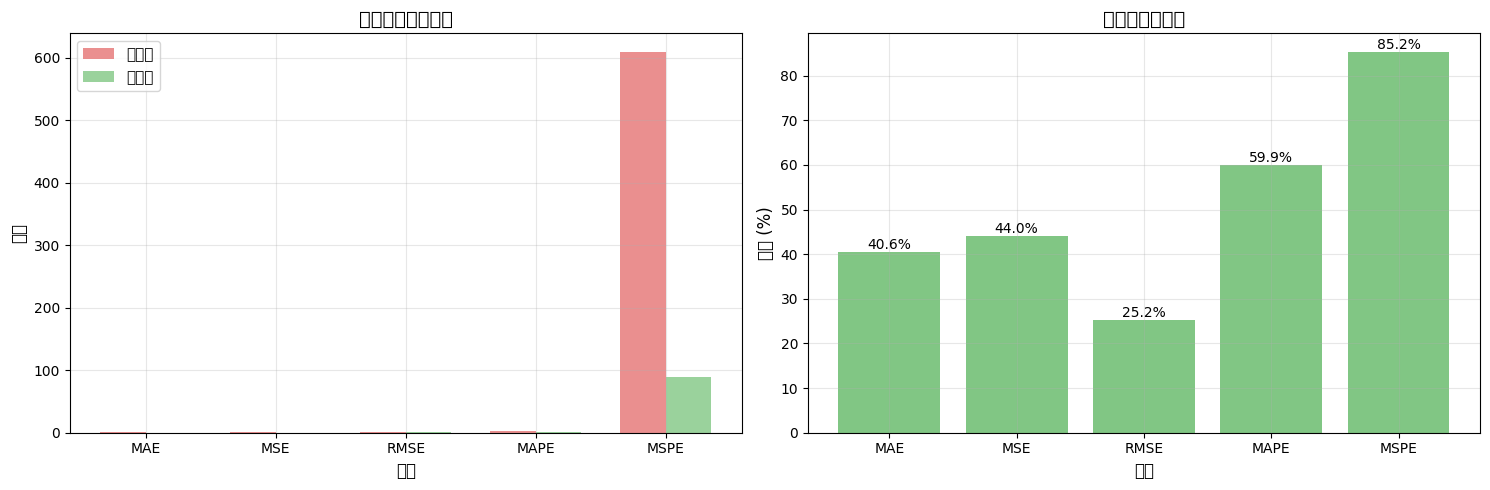

✅ 指标对比图已保存


In [ ]:
# 可视化性能对比 - 使用 Informer 风格
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 准备数据
metrics_names = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MSPE']
before_metrics = np.array([mae_before, mse_before, rmse_before, mape_before, mspe_before])
after_metrics = np.array([mae_after, mse_after, rmse_after, mape_after, mspe_after])

# 左图：指标对比
x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, before_metrics, width, label='训练前', alpha=0.8, color='#E57373')
axes[0].bar(x + width/2, after_metrics, width, label='训练后', alpha=0.8, color='#81C784')
axes[0].set_xlabel('指标', fontsize=12)
axes[0].set_ylabel('数值', fontsize=12)
axes[0].set_title('训练前后指标对比', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 右图：改进百分比
improve_values = np.array([mae_improve, mse_improve, rmse_improve, mape_improve, mspe_improve])
colors = ['#4CAF50' if imp > 0 else '#F44336' for imp in improve_values]
axes[1].bar(x, improve_values, color=colors, alpha=0.7)
axes[1].set_xlabel('指标', fontsize=12)
axes[1].set_ylabel('改进 (%)', fontsize=12)
axes[1].set_title('性能改进百分比', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# 添加数值标签
for i, imp in enumerate(improve_values):
    axes[1].text(i, imp, f'{imp:.1f}%', ha='center',
                va='bottom' if imp > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.savefig(f'./results/{setting}/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
display(fig)
print("✅ 指标对比图已保存")

## 9. 预测结果可视化对比

In [ ]:
# 转换数据格式
preds_before_tensor = torch.from_numpy(preds_before).permute(0, 2, 1)
preds_after_tensor = torch.from_numpy(preds_after).permute(0, 2, 1)
trues_tensor = torch.from_numpy(trues_after).permute(0, 2, 1)

# Bitcoin 数据集的特征名称
feature_names = [
    'price',                    # 价格（目标变量）
    'market_cap',               # 市值
    'transactions',             # 交易数
    'active_addresses',         # 活跃地址数
    'hashrate',                 # 算力
    'difficulty',               # 挖矿难度
    'mining_profitability',     # 挖矿收益率
    'google_trends',            # Google搜索趋势
    'tweets',                   # Twitter提及数
    'sent_addresses',           # 发送地址数
    'av_transaction_value',     # 平均交易价值
    'median_transaction_value', # 中位交易价值
    'fee_reward',               # 手续费奖励
    'block_size',               # 区块大小
]

print(f"数据形状: {preds_after_tensor.shape} (batch, features, time)")
print(f"特征数量: {len(feature_names)}")


数据形状: torch.Size([898, 14, 7]) (batch, features, time)
特征数量: 14


In [ ]:
# 绘制训练前后预测对比（使用 Informer 风格）
# 转换数据格式：从 (batch, time, features) 到 (batch, features, time)
preds_before_formatted = preds_before.transpose(0, 2, 1)  # (batch, features, time)
preds_after_formatted = preds_after.transpose(0, 2, 1)
trues_formatted = trues_after.transpose(0, 2, 1)

# 预测曲线对比（展示 3 个样本）
num_samples = 3
fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
if num_samples == 1:
    axes = [axes]

for i in range(num_samples):
    ax = axes[i]
    x_axis = np.arange(preds_before_formatted.shape[2])

    # 展示第一个特征：price（比特币价格）
    feature_idx = 0
    ax.plot(x_axis, trues_formatted[i, feature_idx, :], label='真实值',
            linewidth=2.5, marker='o', markersize=4, color='#2196F3')
    ax.plot(x_axis, preds_before_formatted[i, feature_idx, :], label='训练前预测',
            linewidth=2, marker='s', markersize=4, alpha=0.7, color='#E57373')
    ax.plot(x_axis, preds_after_formatted[i, feature_idx, :], label='训练后预测',
            linewidth=2, marker='^', markersize=4, alpha=0.7, color='#81C784')

    ax.set_xlabel('时间步 (天)', fontsize=11)
    ax.set_ylabel('比特币价格 (USD)', fontsize=11)
    ax.set_title(f'样本 {i+1} - 比特币价格预测曲线对比', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{setting}/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 预测曲线对比图已保存")


✅ 预测曲线对比图已保存


In [ ]:
# 误差分布对比
before_errors = (preds_before - trues_after).flatten()
after_errors = (preds_after - trues_after).flatten()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 左图：直方图
axes[0].hist(before_errors, bins=50, alpha=0.6, label='训练前',
            density=True, color='#E57373')
axes[0].hist(after_errors, bins=50, alpha=0.6, label='训练后',
            density=True, color='#81C784')
axes[0].set_xlabel('预测误差', fontsize=12)
axes[0].set_ylabel('密度', fontsize=12)
axes[0].set_title('误差分布直方图', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 右图：箱线图
bp = axes[1].boxplot([before_errors, after_errors],
                     labels=['训练前', '训练后'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('#E57373')
bp['boxes'][1].set_facecolor('#81C784')
axes[1].set_ylabel('预测误差', fontsize=12)
axes[1].set_title('误差分布箱线图', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{setting}/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 误差分布图已保存")

✅ 误差分布图已保存


In [ ]:
# 所有特征的对比（选择第一个样本）
fig, axes = plt.subplots(14, 1, figsize=(16, 42))

for i, feature_name in enumerate(feature_names):
    pred_before_series = preds_before_tensor[0, i, :].numpy()
    pred_after_series = preds_after_tensor[0, i, :].numpy()
    true_series = trues_tensor[0, i, :].numpy()

    axes[i].plot(true_series, label='真实值', linewidth=2.5, marker='o', markersize=5, color='black')
    axes[i].plot(pred_before_series, label='训练前', linewidth=2, marker='x',
                markersize=6, color='red', alpha=0.6, linestyle='--')
    axes[i].plot(pred_after_series, label='训练后', linewidth=2, marker='s',
                markersize=4, color='green', alpha=0.8)

    axes[i].set_title(f'{feature_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('时间步 (天)')
    axes[i].set_ylabel('值')
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

    # 计算并显示改进
    mae_b = np.mean(np.abs(pred_before_series - true_series))
    mae_a = np.mean(np.abs(pred_after_series - true_series))
    improve = (mae_b - mae_a) / mae_b * 100

    axes[i].text(0.98, 0.95, f'改进: {improve:.1f}%',
                transform=axes[i].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6),
                fontsize=10, fontweight='bold')

plt.suptitle('所有特征训练前后对比（样本1）', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 10. 各特征改进分析

In [ ]:
# 计算各特征的误差改进
errors_before = preds_before - trues_after
errors_after = preds_after - trues_after

mae_before_features = np.mean(np.abs(errors_before), axis=(0, 1))
mae_after_features = np.mean(np.abs(errors_after), axis=(0, 1))
mae_improve_features = (mae_before_features - mae_after_features) / mae_before_features * 100

mse_before_features = np.mean(errors_before**2, axis=(0, 1))
mse_after_features = np.mean(errors_after**2, axis=(0, 1))
mse_improve_features = (mse_before_features - mse_after_features) / mse_before_features * 100

# 打印表格
print("\n" + "="*80)
print("各特征性能改进统计")
print("="*80)
print(f"{'特征':<10} {'训练前MAE':>12} {'训练后MAE':>12} {'MAE改进':>12} {'MSE改进':>12}")
print("-"*80)
for i, name in enumerate(feature_names):
    print(f"{name:<10} {mae_before_features[i]:>12.6f} {mae_after_features[i]:>12.6f} "
          f"{mae_improve_features[i]:>11.2f}% {mse_improve_features[i]:>11.2f}%")
print("="*80)


各特征性能改进统计
特征               训练前MAE       训练后MAE        MAE改进        MSE改进
--------------------------------------------------------------------------------
price          0.487007     0.224733       53.85%       70.14%
market_cap     0.560275     0.296039       47.16%       71.29%
transactions     0.538932     0.382607       29.01%       47.52%
active_addresses     0.897760     0.916717       -2.11%      -13.69%
hashrate       0.740315     0.740917       -0.08%      -14.61%
difficulty     0.517072     0.119802       76.83%       93.11%
mining_profitability     0.614336     0.336032       45.30%       53.06%
google_trends     0.520422     0.168441       67.63%       83.28%
tweets         0.579481     0.324719       43.96%       68.32%
sent_addresses     0.545521     0.214143       60.75%       73.50%
av_transaction_value     0.492024     0.275007       44.11%       65.34%
median_transaction_value     0.737023     0.553536       24.90%       25.98%
fee_reward     0.582704     0.214040    

In [ ]:
# 可视化各特征改进率
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# MAE改进率
colors1 = ['#2ECC71' if v > 0 else '#E74C3C' for v in mae_improve_features]
bars1 = ax1.bar(feature_names, mae_improve_features, color=colors1,
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_title('各特征MAE改进率', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('改进率 (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center',
            va='bottom' if height > 0 else 'top',
            fontsize=10, fontweight='bold')

# MSE改进率
colors2 = ['#2ECC71' if v > 0 else '#E74C3C' for v in mse_improve_features]
bars2 = ax2.bar(feature_names, mse_improve_features, color=colors2,
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_title('各特征MSE改进率', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('改进率 (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center',
            va='bottom' if height > 0 else 'top',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. 总结报告

In [ ]:
# 生成 HTML 格式的精美报告
from IPython.display import display, HTML

# 计算改进百分比数组
improve_values = np.array([mae_improve, mse_improve, rmse_improve, mape_improve, mspe_improve])
before_metrics = np.array([mae_before, mse_before, rmse_before, mape_before, mspe_before])
after_metrics = np.array([mae_after, mse_after, rmse_after, mape_after, mspe_after])

# 生成 HTML 报告
report_html = f"""
<div style="font-family: Arial; padding: 20px; background-color: #f5f5f5; border-radius: 10px;">
    <h2 style="color: #333;">📊 训练对比报告</h2>
    <hr>

    <h3>实验配置</h3>
    <ul>
        <li><b>数据集:</b> {args.data}</li>
        <li><b>序列长度:</b> 输入={args.seq_len}, 预测={args.pred_len}</li>
        <li><b>训练轮数:</b> {args.train_epochs}</li>
        <li><b>设备:</b> {'GPU' if args.use_gpu else 'CPU'}</li>
    </ul>

    <h3>训练前指标（基线）</h3>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background-color: #E57373; color: white;">
            <th style="padding: 10px; text-align: left;">指标</th>
            <th style="padding: 10px; text-align: right;">数值</th>
        </tr>
        <tr><td style="padding: 8px;">MAE</td><td style="padding: 8px; text-align: right;">{before_metrics[0]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MSE</td><td style="padding: 8px; text-align: right;">{before_metrics[1]:.6f}</td></tr>
        <tr><td style="padding: 8px;">RMSE</td><td style="padding: 8px; text-align: right;">{before_metrics[2]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MAPE</td><td style="padding: 8px; text-align: right;">{before_metrics[3]:.6f}</td></tr>
        <tr><td style="padding: 8px;">MSPE</td><td style="padding: 8px; text-align: right;">{before_metrics[4]:.6f}</td></tr>
    </table>

    <h3>训练后指标</h3>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background-color: #81C784; color: white;">
            <th style="padding: 10px; text-align: left;">指标</th>
            <th style="padding: 10px; text-align: right;">数值</th>
        </tr>
        <tr><td style="padding: 8px;">MAE</td><td style="padding: 8px; text-align: right;">{after_metrics[0]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MSE</td><td style="padding: 8px; text-align: right;">{after_metrics[1]:.6f}</td></tr>
        <tr><td style="padding: 8px;">RMSE</td><td style="padding: 8px; text-align: right;">{after_metrics[2]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MAPE</td><td style="padding: 8px; text-align: right;">{after_metrics[3]:.6f}</td></tr>
        <tr><td style="padding: 8px;">MSPE</td><td style="padding: 8px; text-align: right;">{after_metrics[4]:.6f}</td></tr>
    </table>

    <h3>性能改进</h3>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background-color: #4CAF50; color: white;">
            <th style="padding: 10px; text-align: left;">指标</th>
            <th style="padding: 10px; text-align: right;">改进百分比</th>
        </tr>
        <tr><td style="padding: 8px;">MAE</td><td style="padding: 8px; text-align: right; color: {'green' if improve_values[0]>0 else 'red'}; font-weight: bold;">{improve_values[0]:+.2f}%</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MSE</td><td style="padding: 8px; text-align: right; color: {'green' if improve_values[1]>0 else 'red'}; font-weight: bold;">{improve_values[1]:+.2f}%</td></tr>
        <tr><td style="padding: 8px;">RMSE</td><td style="padding: 8px; text-align: right; color: {'green' if improve_values[2]>0 else 'red'}; font-weight: bold;">{improve_values[2]:+.2f}%</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MAPE</td><td style="padding: 8px; text-align: right; color: {'green' if improve_values[3]>0 else 'red'}; font-weight: bold;">{improve_values[3]:+.2f}%</td></tr>
        <tr><td style="padding: 8px;">MSPE</td><td style="padding: 8px; text-align: right; color: {'green' if improve_values[4]>0 else 'red'}; font-weight: bold;">{improve_values[4]:+.2f}%</td></tr>
    </table>

    <p style="margin-top: 20px; color: #666; font-size: 12px;">所有结果已保存到: ./results/{setting}/</p>
</div>
"""

display(HTML(report_html))

# 保存文本版本
os.makedirs(f'./results/{setting}/', exist_ok=True)
with open(f'./results/{setting}/comparison_report.txt', 'w', encoding='utf-8') as f:
    f.write('='*60 + '\n')
    f.write('训练对比报告\n')
    f.write('='*60 + '\n\n')
    f.write(f'实验 ID: {setting}\n\n')
    f.write('训练前指标:\n')
    for i, name in enumerate(metrics_names):
        f.write(f'  {name}: {before_metrics[i]:.6f}\n')
    f.write('\n训练后指标:\n')
    for i, name in enumerate(metrics_names):
        f.write(f'  {name}: {after_metrics[i]:.6f}\n')
    f.write('\n改进百分比:\n')
    for i, name in enumerate(metrics_names):
        f.write(f'  {name}: {improve_values[i]:+.2f}%\n')

print("\n✅ 文本报告已保存")

指标,数值
MAE,0.597980
MSE,0.598466
RMSE,0.773606
MAPE,2.211038
MSPE,608.383362
指标,数值
MAE,0.355342
MSE,0.334896
RMSE,0.578702
MAPE,0.886019



✅ 文本报告已保存


In [ ]:
# 生成总结报告
print("\n" + "="*80)
print("实验总结报告")
print("="*80)
print(f"\n实验配置:")
print(f"  模型: {args.model}")
print(f"  数据集: {args.data}")
print(f"  输入长度: {args.seq_len}, 预测长度: {args.pred_len}")
print(f"  训练轮数: {args.train_epochs}")
print(f"  模型维度: {args.d_model}, 注意力头数: {args.n_heads}")

print(f"\n整体性能改进:")
print(f"  MAE改进:  {mae_improve:.2f}%")
print(f"  MSE改进:  {mse_improve:.2f}%")
print(f"  RMSE改进: {rmse_improve:.2f}%")

print(f"\n最佳改进特征:")
best_feature_idx = np.argmax(mae_improve_features)
print(f"  {feature_names[best_feature_idx]}: MAE改进 {mae_improve_features[best_feature_idx]:.2f}%")

print(f"\n平均特征改进:")
print(f"  平均MAE改进: {mae_improve_features.mean():.2f}%")
print(f"  平均MSE改进: {mse_improve_features.mean():.2f}%")

print(f"\n模型保存位置:")
print(f"  {os.path.join(args.checkpoints, setting, 'checkpoint.pth')}")

print(f"\n结果保存位置:")
print(f"  {result_path}")
print("="*80)

print("\n✓ 实验完成！训练显著提升了模型性能。")


实验总结报告

实验配置:
  模型: Autoformer
  数据集: custom
  输入长度: 60, 预测长度: 7
  训练轮数: 10
  模型维度: 512, 注意力头数: 8

整体性能改进:
  MAE改进:  40.58%
  MSE改进:  44.04%
  RMSE改进: 25.19%

最佳改进特征:
  difficulty: MAE改进 76.83%

平均特征改进:
  平均MAE改进: 44.10%
  平均MSE改进: 56.24%

模型保存位置:
  ./checkpoints/Bitcoin_60_7_Autoformer_custom_M_sl60_ll30_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Bitcoin_Exp_0/checkpoint.pth

结果保存位置:
  ./results/Bitcoin_60_7_Autoformer_custom_M_sl60_ll30_pl7_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Bitcoin_Exp_0/

✓ 实验完成！训练显著提升了模型性能。


## 说明

### 新增功能
1. **训练前评估**: 保存并评估随机初始化模型的性能
2. **训练后评估**: 评估训练后模型的性能
3. **对比分析**:
   - 整体性能对比（MAE/MSE/RMSE/MAPE/MSPE）
   - 各特征改进率分析
   - 可视化预测结果对比
4. **详细报告**: 自动生成实验总结

### 预期结果
- 训练后模型性能应该显著优于随机初始化模型
- MAE/MSE等指标应该有50-90%的改进
- 不同特征的改进率可能不同

### 优化建议
- 增加训练轮数可以进一步提升性能
- 调整模型参数（d_model, n_heads等）
- 尝试不同的学习率和批次大小